In [1]:
## Others
import warnings
warnings.filterwarnings("ignore")

## basic + datetime 
import pandas as pd
import numpy as np
import time
from datetime import datetime

## data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Dispaly max column
pd.pandas.set_option('display.max_columns',None)
## Display max rows
#pd.pandas.set_option('display.max_rows', None)

## time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [2]:
import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [3]:
#Logger
log = logging.getLogger()
log.info('Time_series_analysis')

INFO:root:Time_series_analysis


In [4]:
## loading store data using pandas library
store_df = pd.read_csv("data/clean_store.csv", low_memory = False)

## loading train data using pandas library
train_df = pd.read_csv("data/clean_train.csv", parse_dates = True, low_memory = False)

In [5]:
train_store_df=store_df.merge(train_df,on="Store")
train_store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,4,2015-07-30,5020,546,1,1,0,1,2015,7,30,31,9.194139
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3,2015-07-29,4782,523,1,1,0,1,2015,7,29,31,9.143403
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2,2015-07-28,5011,560,1,1,0,1,2015,7,28,31,8.948214
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1,2015-07-27,6102,612,1,1,0,1,2015,7,27,31,9.970588


In [6]:
train_store_df.shape

(1017209, 23)

In [7]:
## convert the Date column to the datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Store            1017209 non-null  int64         
 1   DayOfWeek        1017209 non-null  int64         
 2   Date             1017209 non-null  datetime64[ns]
 3   Sales            1017209 non-null  int64         
 4   Customers        1017209 non-null  int64         
 5   Open             1017209 non-null  int64         
 6   Promo            1017209 non-null  int64         
 7   StateHoliday     1017209 non-null  object        
 8   SchoolHoliday    1017209 non-null  int64         
 9   Year             1017209 non-null  int64         
 10  Month            1017209 non-null  int64         
 11  Day              1017209 non-null  int64         
 12  WeekOfYear       1017209 non-null  int64         
 13  SalePerCustomer  1017209 non-null  float64       
dtypes:

In [8]:
## Set the index
train_df.set_index('Date', inplace = True)

In [9]:
## Display max rows
pd.pandas.set_option('display.max_rows', None)

unique_values = train_store_df[['Store', 'StoreType']].drop_duplicates()
unique_values.head(85)

,Store,StoreType
0,1,c
942,2,a
1884,3,a
2826,4,c
3768,5,a
4710,6,a
5652,7,a
6594,8,a
7536,9,a
8478,10,a


In [10]:
train_store_df['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [11]:
train_store_df['Store'].unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

### Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem?

1. It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.

2. Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset.

In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

We take four stores from store types to represent their group:

1. Store number 2 for StoreType A
2. Store number 85 for StoreType B,
3. Store number 1 for StoreType C
4. Store number 13 for StoreType D.

We take four stores from store types to represent their group: Store number 2 for StoreType A Store number 85 for StoreType B, Store number 1 for StoreType C Store number 13 for StoreType D. It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

# Seasonality

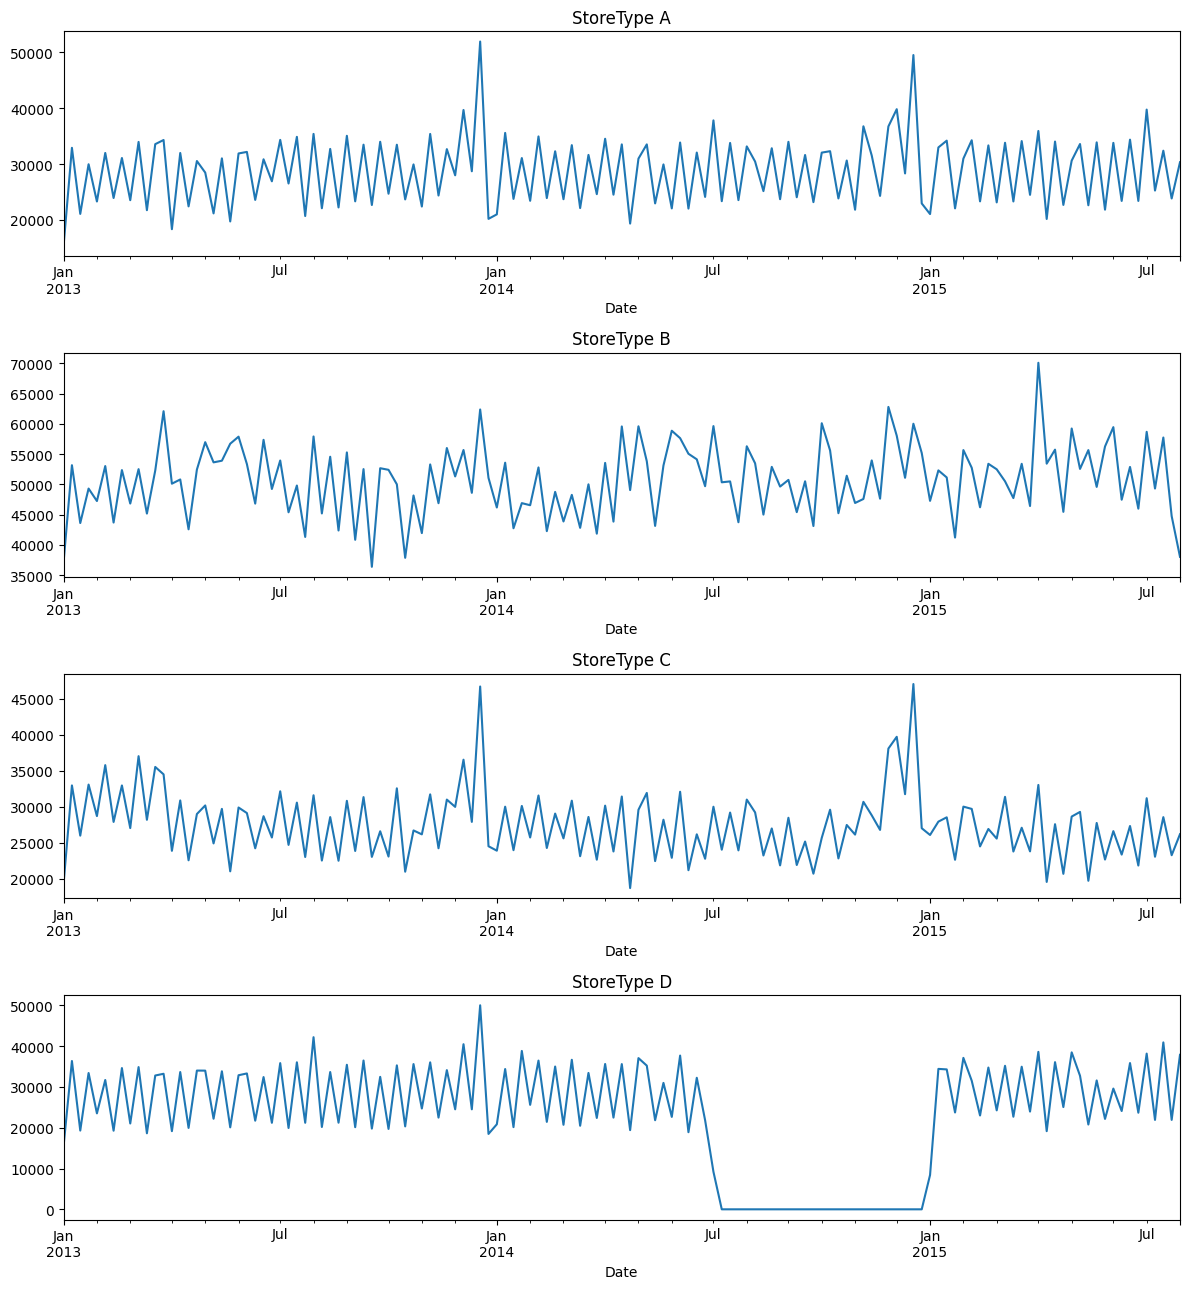

In [12]:
# Preparation: Convert 'Sales' column to float type
train_df['Sales'] = train_df['Sales'].astype(float)

# Store types
store_a_sales = train_df[train_df.Store == 2]['Sales']
store_b_sales = train_df[train_df.Store == 85]['Sales'].sort_index(ascending=True)
store_c_sales = train_df[train_df.Store == 1]['Sales']
store_d_sales = train_df[train_df.Store == 13]['Sales']

# Create subplots
fig, axes = plt.subplots(4, figsize=(12, 13))

# Plot sales for StoreType A
store_a_sales.resample('W').sum().plot(ax=axes[0])
axes[0].set_title('StoreType A')

# Plot sales for StoreType B
store_b_sales.resample('W').sum().plot(ax=axes[1])
axes[1].set_title('StoreType B')

# Plot sales for StoreType C
store_c_sales.resample('W').sum().plot(ax=axes[2])
axes[2].set_title('StoreType C')

# Plot sales for StoreType D
store_d_sales.resample('W').sum().plot(ax=axes[3])
axes[3].set_title('StoreType D')

plt.tight_layout()
plt.show()

**Retail sales for StoreType A and C tend to peak during the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as looks like they were closed.**

## Yearly trend
The next thing to check the presence of a trend in series.

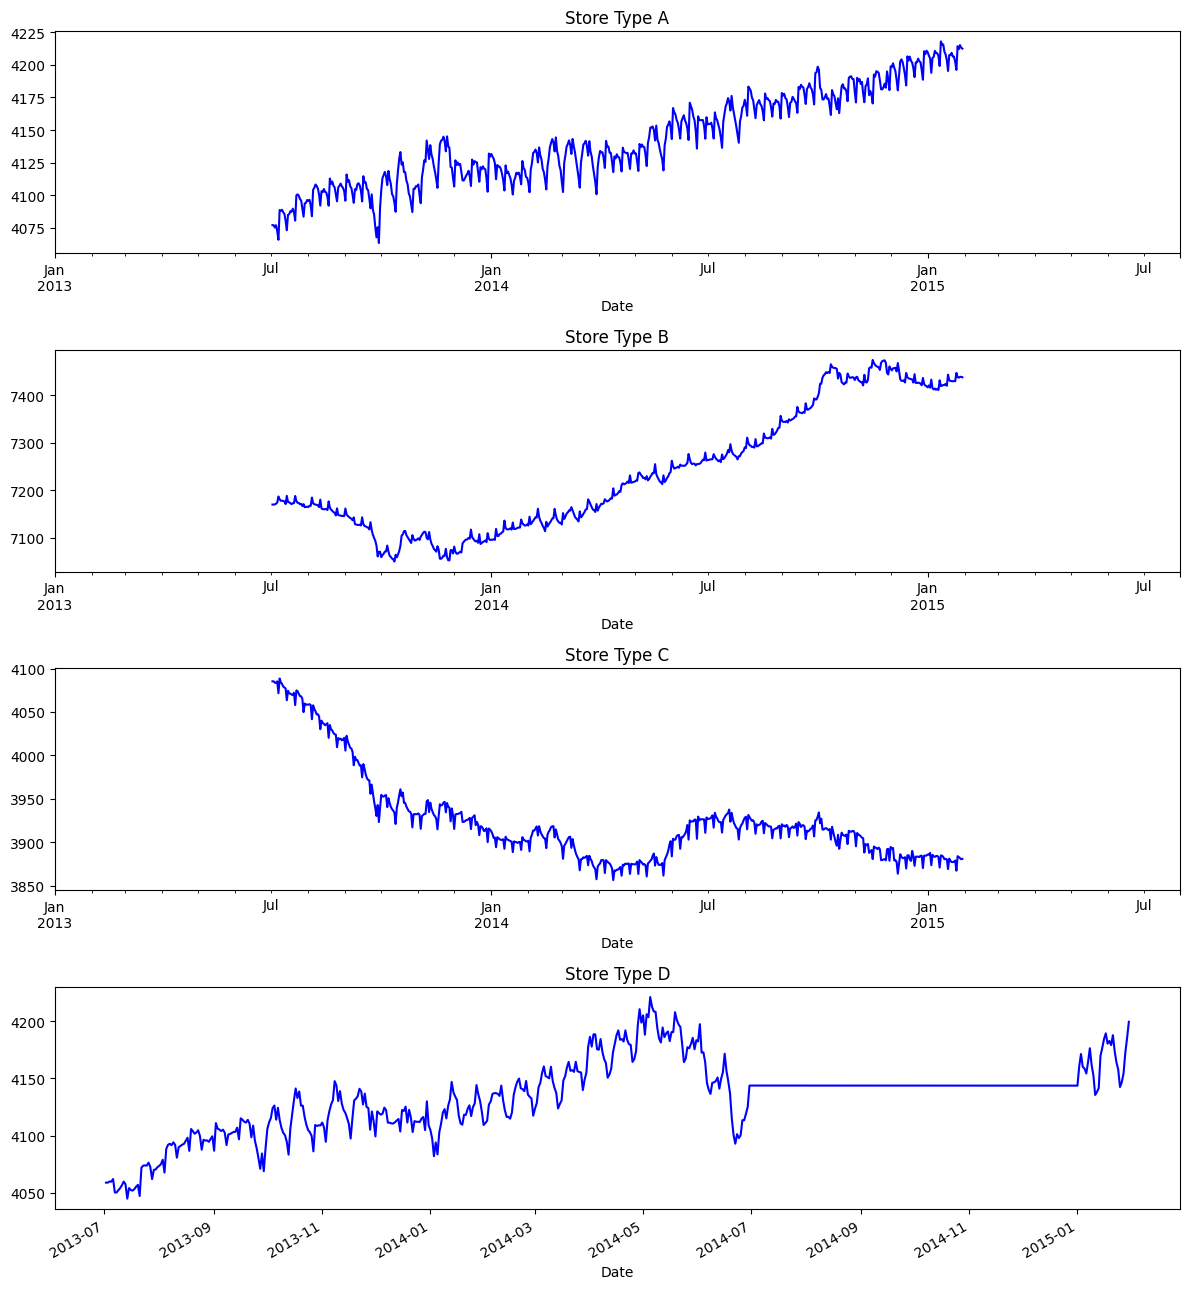

In [13]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

c = 'blue'
# monthly
decomposition_a = seasonal_decompose(store_a_sales, model = 'additive', period = 365)
decomposition_a.trend.plot(color = c, ax = ax1, title="Store Type A")

decomposition_b = seasonal_decompose(store_b_sales, model = 'additive', period = 365)
decomposition_b.trend.plot(color = c, ax = ax2,title="Store Type B")

decomposition_c = seasonal_decompose(store_c_sales, model = 'additive', period = 365)
decomposition_c.trend.plot(color = c, ax = ax3,title="Store Type C")

decomposition_d = seasonal_decompose(store_d_sales, model = 'additive', period = 365)
decomposition_d.trend.plot(color = c, ax = ax4,title="Store Type D")

plt.tight_layout()
plt.show()

**Observation: Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset.**

# Time Series Analysis and Forecasting with Facebook Prophet

**The Facebook Prophet release date was on February 23, 2017.**

**Prophet is a forecasting tool that is available in R and Python. It is an open source software that was released by Facebook's Core Data Science team. It enables performing automated forecasting.**

**Prophet is based on a Bayesian approach that allows for uncertainty estimation in the predictions. It can capture complex patterns in the data such as seasonality, trends, and the effect of holidays.**

In [15]:
# importing data
df = pd.read_csv("data/train.csv", parse_dates = True, low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [16]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


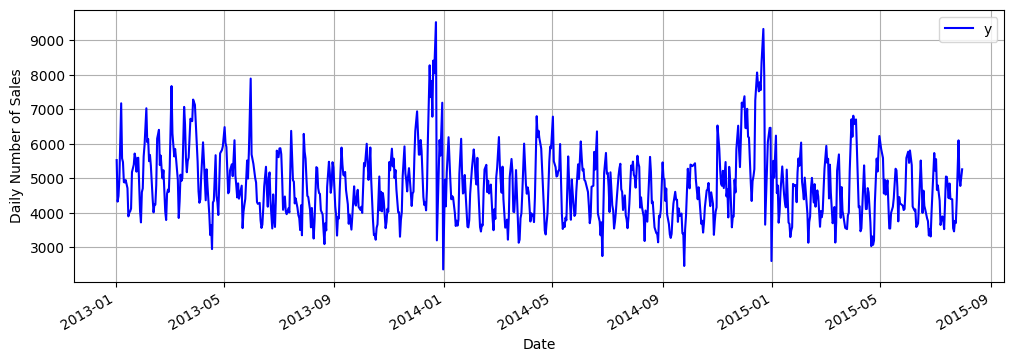

In [17]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
plt.grid(True)
ax.set_xlabel('Date')
plt.show()

## Modeling Holidays

Prophet also allows to model for holidays, and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which certain stores are also closing their doors.

In [18]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [19]:
## Create a Prophet model with a 95% confidence interval and holidays(the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

## dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\Admin\Pharmaceutical_Sales_Prediction_Across_Multiple_Stores_\venv\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Admin\AppData\Local\Temp\tmp52bvdudq\r0tf0dbk.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Admin\AppData\Local\Temp\tmp52bvdudq\bbiqh7nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Admin\\Pharmaceutical_Sales_Prediction_Across_Multiple_Stores_\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=34614', 'data', 'file=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmp52bvdudq\\r0tf0dbk.json', 'init=C:\\Users\\Admin\\AppData\\Local\\Temp\\tmp52bvdudq\\bbiqh7nx.json', 'output', 'file=C:\\Users\\Admin\\AppData\\Loc

First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [20]:
## predictions
forecast = my_model.predict(future_dates)

## preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.365599,2438.838971,5824.174204
817,2015-09-06,4087.133680,2534.189375,5744.669852
818,2015-09-07,4161.832882,2588.136700,5745.511310
819,2015-09-08,3664.289094,2061.366514,5348.651643
820,2015-09-09,3551.120751,1962.194936,5247.306368
821,2015-09-10,3462.610581,1829.514740,5199.114402
822,2015-09-11,3717.249798,2147.648618,5345.245129


**Observation: The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.**

In [21]:
import prophet
from prophet.plot import plot_plotly,plot_components_plotly

In [22]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

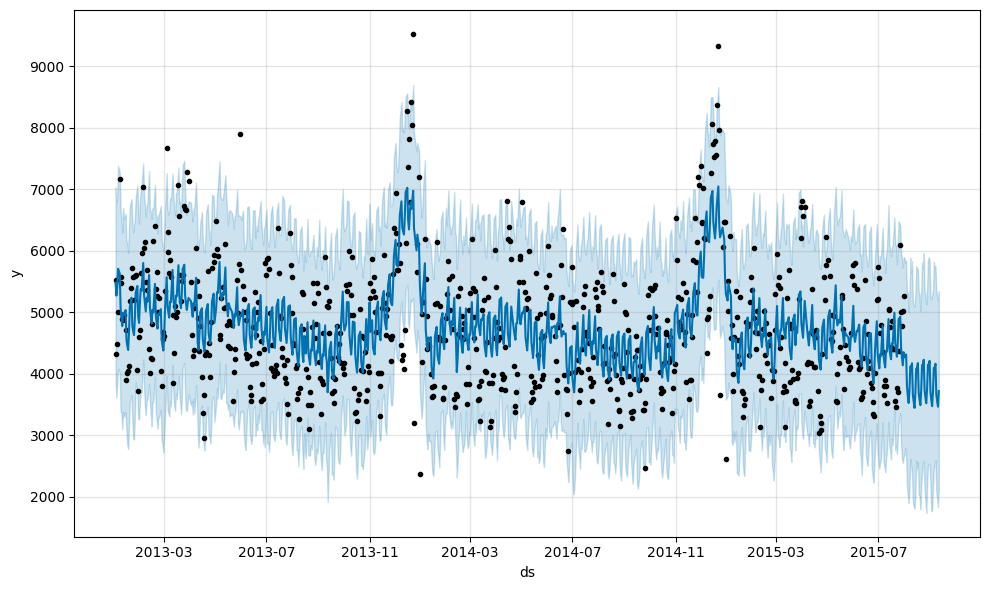

In [28]:
# visualizing predicions
my_model.plot(forecast);

**Observation: Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).**

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

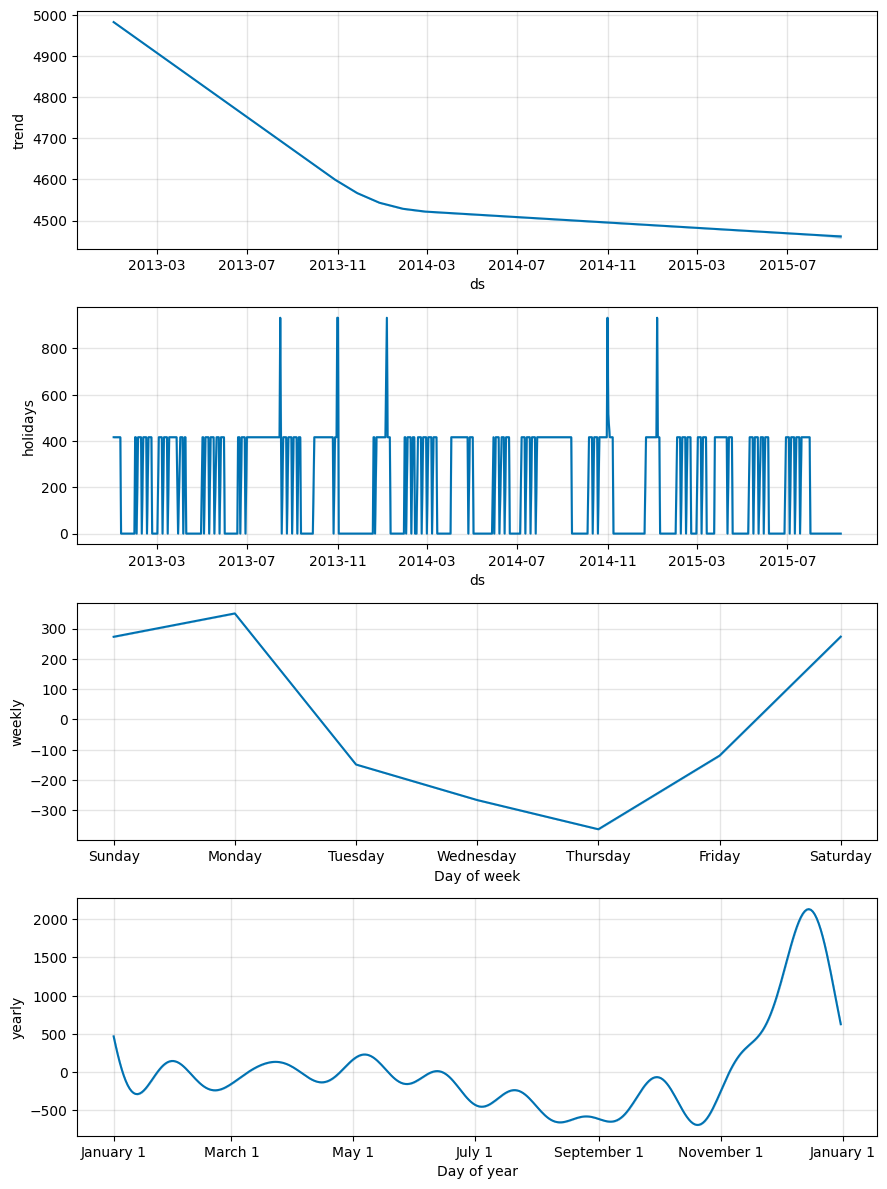

In [30]:
my_model.plot_components(forecast);

**Observation: The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.**